# Multivariate Linear Regression on Canada economic Data

The objective of this task is to analyse the impact of macro-economics factors on the P&L statement.

Dependent Variables:
1. Net Sales
1. Gross Profit
1. Total SG&A
1. Membership & Other Income
1. Segment Operating Income

Assumptions:
1. All the data used is for Walmart, Canada

Approaches Used:
1. Polyvariate Multivariate Regression Model

In [24]:
# Machine learning packages and libraries
import tensorflow

# Statistical analysis packages and libraries
import sklearn
import pandas as pd
import tensorflow_probability
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Graphing and plotting libraries
import matplotlib
import matplotlib.pyplot as plt


### Get the dataset For Analysis

Source:  Worldbank
URL: https://data.worldbank.org/country/CA

In [34]:
## Extraction and Preprocessing of data

# Read data from CSV to dataframe
canada_df = pd.read_csv('pnl_dataset/canada_cleaned.csv')


In [35]:
## Cleaning data

# Dropping data earlier than 2000, we do not have dependent variable data before 2000.
canada_df.drop('year.1', axis=1, inplace=True)
canada_df = canada_df[canada_df.year >= 2000]


<AxesSubplot:>

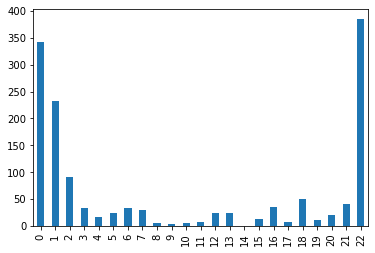

In [36]:
# Frequency distribution of missing values per independent variable
freq_distribution_missing_values = canada_df.isna().sum()
freq_distribution_missing_values.value_counts().sort_index(axis=0, ascending=True).plot(kind='bar')


In [5]:
# Dropping all the independent variables have more than 99% missing values
# As the number of independent variables(macroeconomic factors is close to 1440)
total_rows = canada_df.shape[0]

filtered_columns = list(freq_distribution_missing_values.loc[lambda x : (x/total_rows) < 0.01].index)
canada_df = canada_df[filtered_columns]

In [6]:
# Load the P and L walmart data
# Assuming all the data is for Walmart, Canada.
walmart_df = pd.read_csv('pnl_dataset/pnl_walmart.csv')

In [50]:
# We need to identify inpedentent variables which has a high correration with dependent variable.
# We need to do this for each P&L dependent variable seperately

# store correlation results {dependent_var: [list of independent var]}
highly_correlated_columns = {}

for pnl_dependent_var in walmart_df.columns:
    # Ignore the year column
    if pnl_dependent_var != 'year':
        
        # Add the P&L dependent column into the input df one by one
        dataset_ = canada_df.copy()
        dataset_ = dataset_.merge(walmart_df[['year', pnl_dependent_var]], on='year')
        independent_var_df = dataset_.loc[:, dataset_.columns != pnl_dependent_var]
        
        # Get correlation matrix
        correlation_matrix = independent_var_df.corrwith(dataset_[pnl_dependent_var])
        filtered_columns = list(correlation_matrix.loc[lambda x : abs(x) >= 0.95].index)
        ## TODO: Find correlation between each inpendent variable,
                    # this is import to eliminate one paramater dominating the regrestion.
        
        # we will use this information during regression
        if 'year' not in filtered_columns:
            filtered_columns.append('year')

        highly_correlated_columns[pnl_dependent_var] = filtered_columns
        
        print(f"For dependent var: {pnl_dependent_var}\n count of vars: {len(filtered_columns)}\n")


For dependent var: Net Sales
 count of vars: 80

For dependent var: Membership and Other Income
 count of vars: 1

For dependent var: Gross Profit
 count of vars: 79

For dependent var: Segment Operating income
 count of vars: 5

For dependent var: Total SG&A
 count of vars: 75



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-p

In [6]:
# Get data to predict for next 4 years --> refer to prepare_future_data.ipynb for the same.
# Using the data from last 4 years, we have got a growth rate, using which the values for the 140 independent variables is generated/predicted.

input_for_prediction = pd.read_csv('pnl_dataset/features_to_pridict.csv')

In [57]:
## Multivariate polynomial Regression

print("Model Accuracy:\n*************************\n ")
predicted_values = {'year': [i for i in  range (2022, 2026)]}
for dependent_var in highly_correlated_columns:
    
    # Add the P&L dependent column into the input df one by one
    dataset_ = canada_df.copy()
    dataset_ = dataset_[highly_correlated_columns[dependent_var]]
    dataset_ = dataset_.merge(walmart_df[['year', dependent_var]], on='year')
        
    #seperate test and training sets
    train_df, test_df = train_test_split(dataset_, test_size=0.1)

    #create a df for independent vars
    train_independent_var_df = train_df.iloc[:, :-1]
    test_independent_var_df = test_df.iloc[:, :-1]

    #prepare independent vars for poly reg
    poly_preprocessing = PolynomialFeatures(degree=1)
    poly_train_independent_var_df = poly_preprocessing.fit_transform(train_independent_var_df)
    poly_test_independent_var_df = poly_preprocessing.fit_transform(test_independent_var_df)
    poly_predict_independent_var_df = poly_preprocessing.fit_transform(input_for_prediction[highly_correlated_columns[dependent_var]])

    #create a df for dependent var
    train_dependent_var_df = train_df.loc[:, [dependent_var]]
    test_dependent_var_df = test_df.loc[:, [dependent_var]]

    # Create a Poly Linear Regression Model
    poly_reg = linear_model.LinearRegression()
    poly_reg.fit(poly_train_independent_var_df, train_dependent_var_df)
    #print 

    #predict using the poly reg model
    prediction_poly_reg = poly_reg.predict(poly_test_independent_var_df)
        
    # predict future values
    print(f'Dependent var: {dependent_var}')
    predicted_values[dependent_var] = [abs(i[0]) for i in poly_reg.predict(poly_predict_independent_var_df).tolist()]
    
    # Model Accuracy metrix, using R Mean Square Error approach
    print(f"R2 Error: {metrics.r2_score(prediction_poly_reg, test_dependent_var_df)}\n")


Model Accuracy:
*************************
 
Dependent var: Net Sales
R2 Error: 0.9096012844748771

Dependent var: Membership and Other Income
R2 Error: 0.3796865558954229

Dependent var: Gross Profit
R2 Error: 0.9598606591313992

Dependent var: Segment Operating income
R2 Error: 0.9500157108537667

Dependent var: Total SG&A
R2 Error: 0.9947328605886812



/var/folders/c3/_lw7wjz13nngy0hwn8dbmyxw0000gq/T/ipykernel_36634/1325641.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  years_data_with_prediction= sample.append(predicted_value, ignore_index=True)


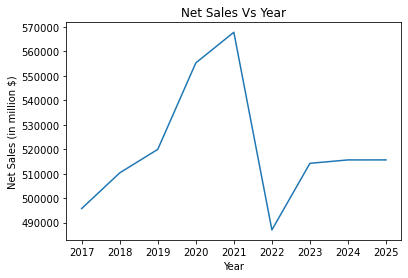

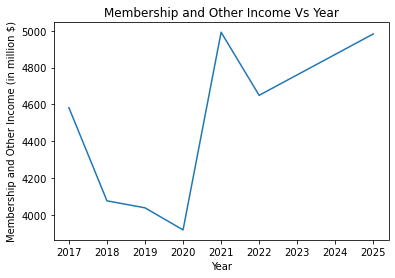

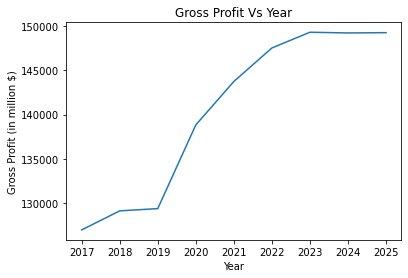

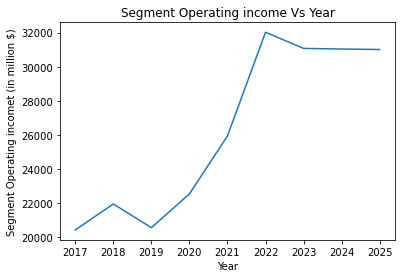

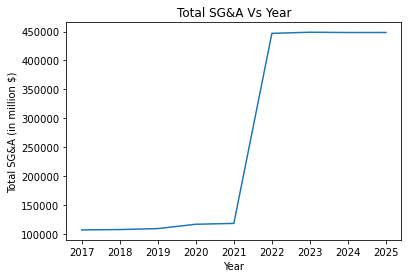

In [32]:
#predicted values, earlier stored in a csv
predicted_value = pd.read_csv('pnl_dataset/pnl_walmart_predicted.csv')

# Actual input data
sample = pd.read_csv('pnl_dataset/pnl_walmart.csv')
sample = sample[sample.year >= 2017]

# Joining them to get a relative graph
years_data_with_prediction= sample.append(predicted_value, ignore_index=True)
years_data_with_prediction

# Line graphs for each of the P&L statements
plt.plot(years_data_with_prediction['year'], years_data_with_prediction['Net Sales'])
plt.title('Net Sales Vs Year')
plt.xlabel('Year')
plt.ylabel('Net Sales (in million $)')
plt.show()

plt.plot(years_data_with_prediction['year'], years_data_with_prediction['Membership and Other Income'])
plt.title('Membership and Other Income Vs Year')
plt.xlabel('Year')
plt.ylabel('Membership and Other Income (in million $)')
plt.show()

plt.plot(years_data_with_prediction['year'], years_data_with_prediction['Gross Profit'])
plt.title('Gross Profit Vs Year')
plt.xlabel('Year')
plt.ylabel('Gross Profit (in million $)')
plt.show()

plt.plot(years_data_with_prediction['year'], years_data_with_prediction['Segment Operating income'])
plt.title('Segment Operating income Vs Year')
plt.xlabel('Year')
plt.ylabel('Segment Operating incomet (in million $)')
plt.show()

plt.plot(years_data_with_prediction['year'], years_data_with_prediction['Total SG&A'])
plt.title('Total SG&A Vs Year')
plt.xlabel('Year')
plt.ylabel('Total SG&A (in million $)')
plt.show()

